In [1]:
import numpy as np

def rmse(y, yhat):
    return np.mean((y - yhat)**2)

In [2]:
n_splits = 5 # cross-fitting and cross-validation splits
data = '401k' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}
xfeat = 'inc' # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
hetero_feats = ['inc'] # list of subset of features to be used for CATE model or the string 'all' for everything

## For semi-synthetic data generation
semi_synth = False # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = True # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
scale = .2 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

In [3]:
from datasets import fetch_data_generator
np.random.state(123)
get_data, abtest, true_cef, true_cate = fetch_data_generator(data=data, semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             scale=scale, true_f=simple_true_cef,
                                                             max_depth=max_depth)
X, D, Y, groups = get_data()

In [4]:
if semi_synth:
    true_ate = np.mean(true_cate(Z))
    print(f'True ATE: {true_ate}')

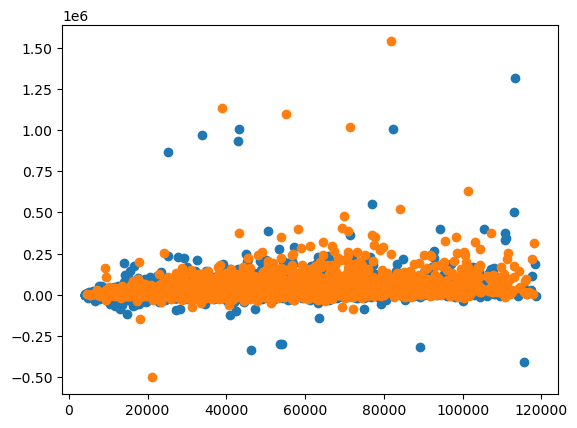

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[D==0]['inc'], Y[D==0])
plt.scatter(X[D==1]['inc'], Y[D==1])
plt.show()

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

param_grid = {
    'max_depth': [2, 5, 9],
    'min_samples_leaf': [50, 100]
}
reg = lambda: GridSearchCV(RandomForestRegressor(random_state=123), param_grid)

param_grid = {
    'max_depth': [2, 5, 9],
    'min_samples_leaf': [10, 50, 100]
}
clf = lambda: GridSearchCV(RandomForestClassifier(random_state=123), param_grid)

In [7]:
Z = X.values
g0 = reg().fit(Z[D==0], Y[D==0])
g1 = reg().fit(Z[D==1], Y[D==1])

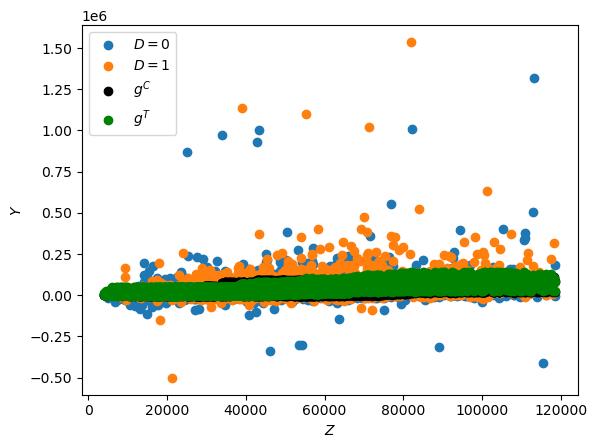

In [8]:
plt.scatter(X[D==0][xfeat], Y[D==0], label='$D=0$')
plt.scatter(X[D==1][xfeat], Y[D==1], label='$D=1$')
plt.scatter(X[xfeat], g0.predict(X.values), color='black', label='$g^C$')
plt.scatter(X[xfeat], g1.predict(X.values), color='green', label='$g^T$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [55]:
# propensity
mu = clf().fit(Z, D)

In [56]:
mu.best_estimator_

RandomForestClassifier(max_depth=9, min_samples_leaf=10, random_state=123)

In [10]:
# X-learner
tau0 = reg().fit(Z[D==0], g1.predict(Z[D==0]) - Y[D==0])
tau1 = reg().fit(Z[D==1], Y[D==1] - g0.predict(Z[D==1]))

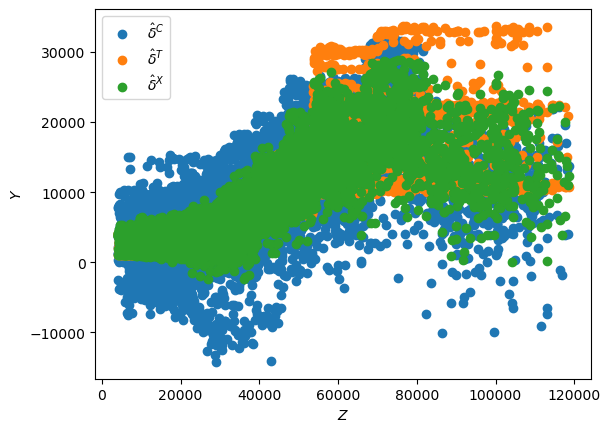

In [57]:
t0 = tau0.predict(X.values)
t1 = tau1.predict(X.values)
m = mu.predict_proba(X.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.scatter(X[xfeat], t0,  label='$\hat{\delta}^C$')
plt.scatter(X[xfeat], t1, label='$\hat{\delta}^T$')
plt.scatter(X[xfeat], tX,  label='$\hat{\delta}^X$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [58]:
import pandas as pd
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 105, 5)))
Ztest = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                    columns=X.columns)
Ztest[xfeat] = grid

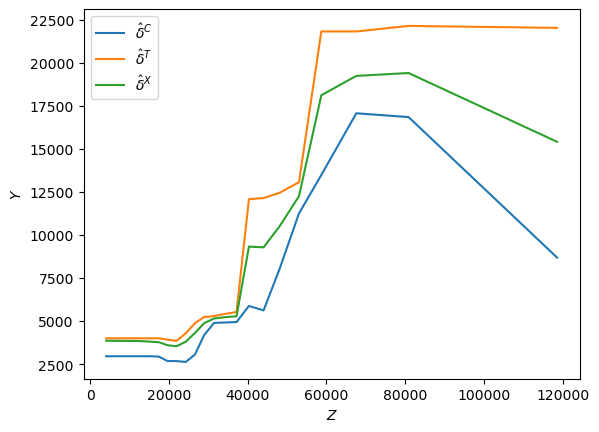

In [59]:
t0 = tau0.predict(Ztest.values)
t1 = tau1.predict(Ztest.values)
m = mu.predict_proba(Ztest.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.plot(grid, t0,  label='$\hat{\delta}^C$')
plt.plot(grid, t1, label='$\hat{\delta}^T$')
plt.plot(grid, tX,  label='$\hat{\delta}^X$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [14]:
# S-Learner
g = reg().fit(np.hstack([D.reshape(-1, 1), Z]), Y)

In [60]:
# IPS-Learner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
tauIPS = reg().fit(Z, Y * (D - m)/cov)

In [61]:
# DR-Learner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
g1preds = g1.predict(Z)
g0preds = g0.predict(Z)
gpreds = g1preds * D + g0preds * (1 - D)
Ydr = (Y - gpreds) * (D - m)/cov + g1preds - g0preds
tauDR = reg().fit(Z, Ydr)

In [62]:
# R-Learner
h = reg().fit(Z, Y)
Yres = Y - h.predict(Z)
Dres = D - mu.predict_proba(Z)[:, 1]

In [63]:
DresClip = np.clip(Dres, 1e-12, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -1e-12) * (Dres<0)
tauR = reg().fit(Z, Yres/DresClip, sample_weight=Dres**2)

In [64]:
# from econml.grf import CausalForest
# tauR = CausalForest(min_samples_leaf=20, max_depth=5, max_samples=.8, inference=False).fit(Z, Dres, Yres)

In [65]:
# DRX-Learner
m = mu.predict_proba(Z)[:, 1]
g0preds = g0.predict(Z)
g1preds = g1.predict(Z)
g0preds = g0preds * (1 - m) + (g1.predict(Z) - tau0.predict(Z)) * m
g1preds = g1preds * m + (g0.predict(Z) + tau1.predict(Z)) * (1 - m)
gpreds = g1preds * D + g0preds * (1 - D)
cov = np.clip(m * (1 - m), 1e-12, np.inf)
Ydr = (Y - gpreds) * (D - m)/cov + g1preds - g0preds
tauDRX = reg().fit(Z, Ydr)

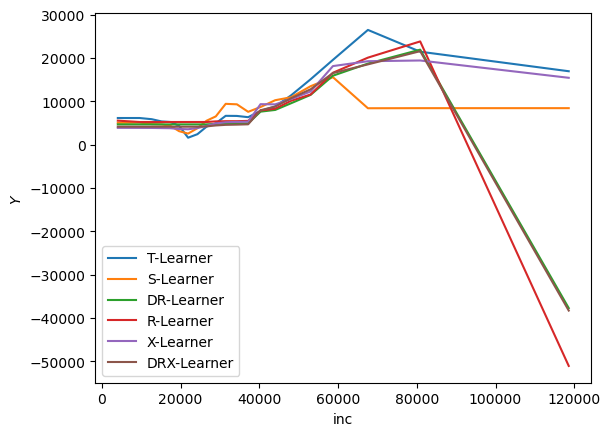

In [66]:
t0 = tau0.predict(Ztest.values)
t1 = tau1.predict(Ztest.values)
tT = g1.predict(Ztest.values) - g0.predict(Ztest.values)
tS = g.predict(np.hstack([np.ones(Ztest.shape[0]).reshape(-1, 1), Ztest.values])) 
tS -= g.predict(np.hstack([np.zeros(Ztest.shape[0]).reshape(-1, 1), Ztest.values]))
tIPS = tauIPS.predict(Ztest.values)
tDR = tauDR.predict(Ztest.values)
tR = tauR.predict(Ztest.values)
m = mu.predict_proba(Ztest.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Ztest.values)

plt.plot(grid, tT, label=f'T-Learner')
plt.plot(grid, tS, label=f'S-Learner')
# plt.plot(Ztest, tIPS, label='IPS-Learner')
plt.plot(grid, tDR, label=f'DR-Learner')
plt.plot(grid, tR, label=f'R-Learner')
plt.plot(grid, tX,  label=f'X-Learner')
plt.plot(grid, tDRX, label=f'DRX-Learner')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

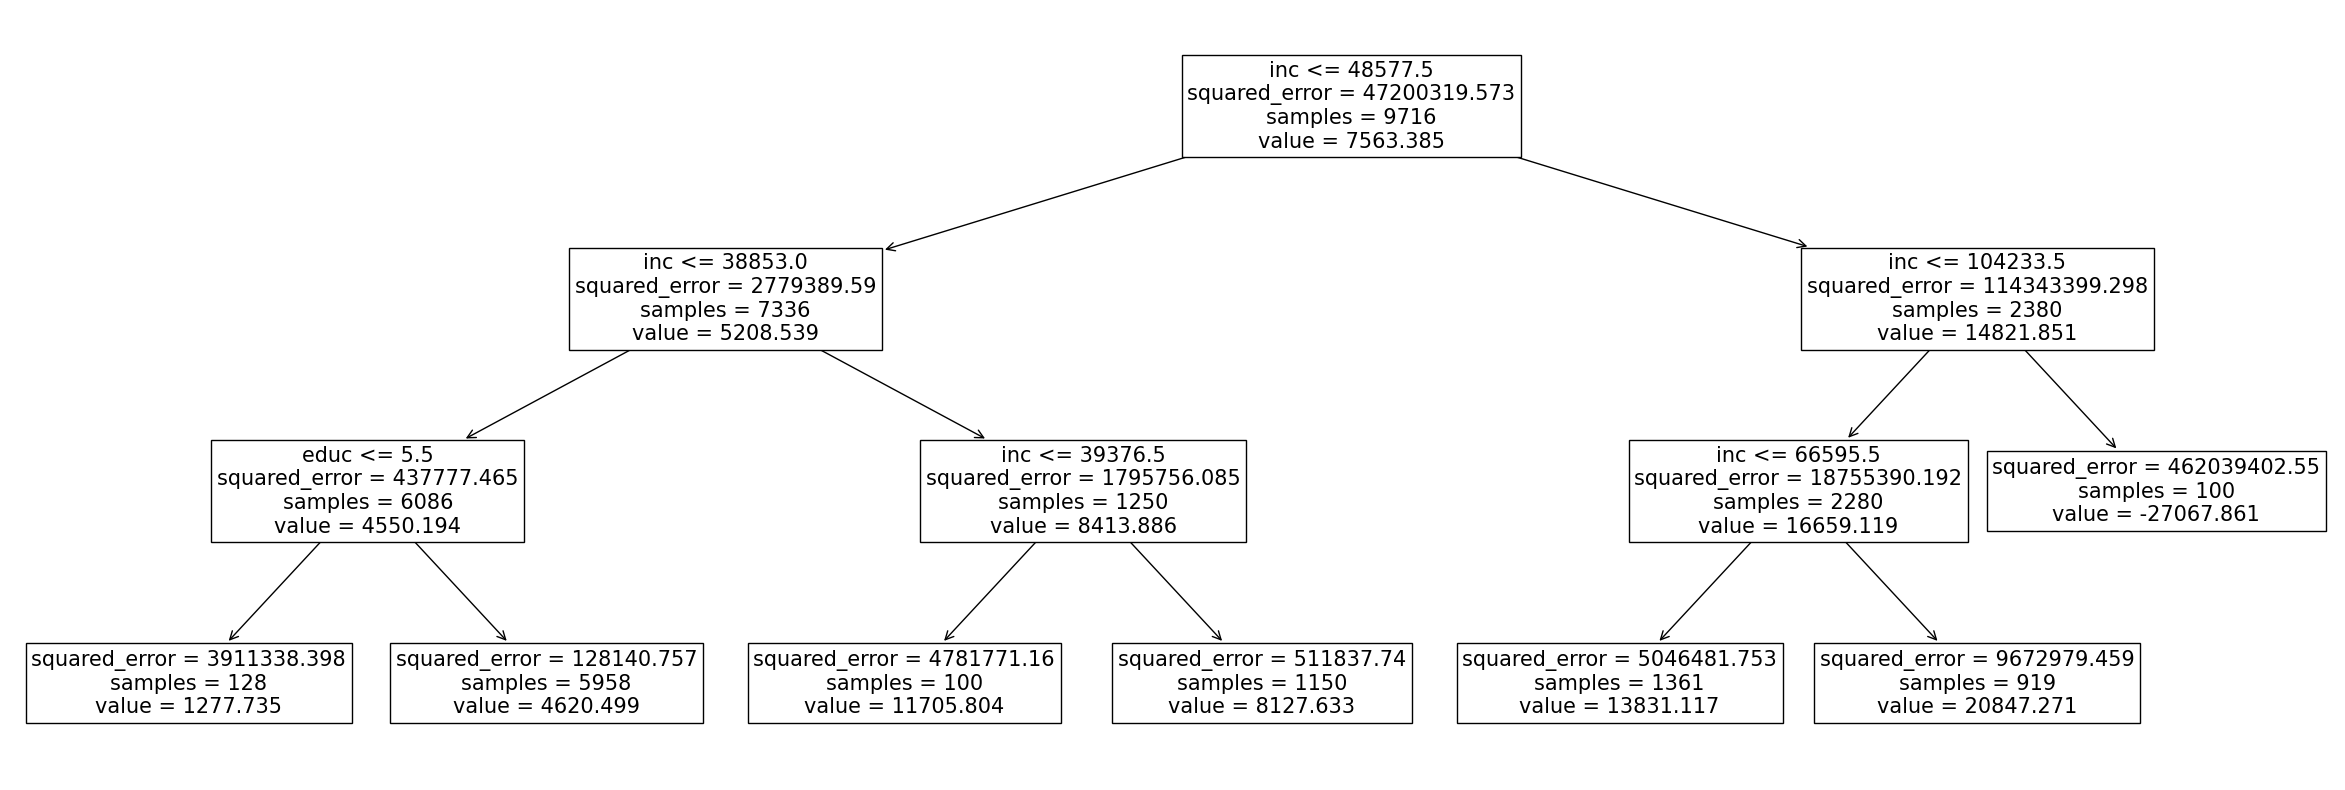

In [23]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=100).fit(X.values, tauDRX.predict(Z))
plt.figure(figsize=(30, 10))
plot_tree(tree, feature_names=X.columns, fontsize=15)
plt.show()

In [24]:
import shap

explainer = shap.Explainer(tauDRX.best_estimator_)
shap_values = explainer.shap_values(Z)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


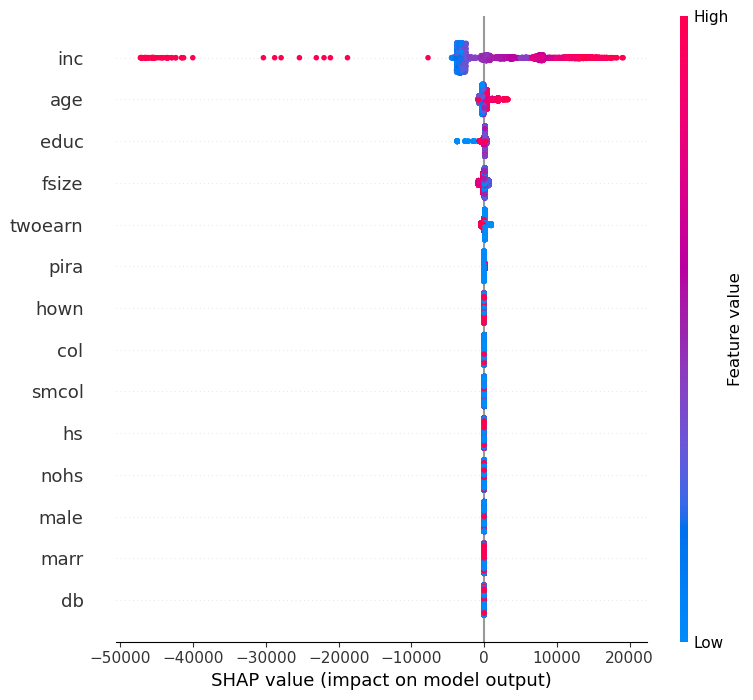

In [25]:
shap.summary_plot(shap_values, X)

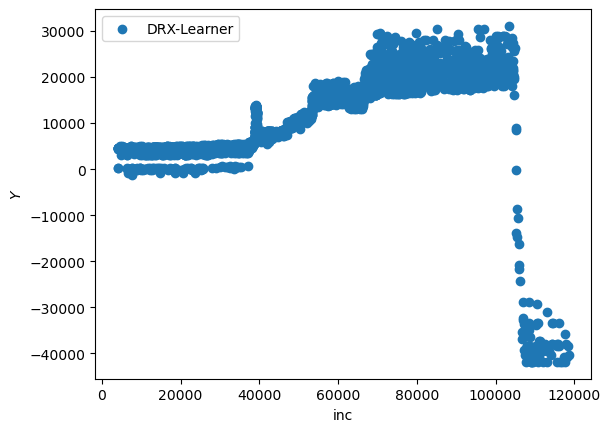

In [26]:
tDRX = tauDRX.predict(X.values)

plt.scatter(X[xfeat], tDRX, label=f'DRX-Learner')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

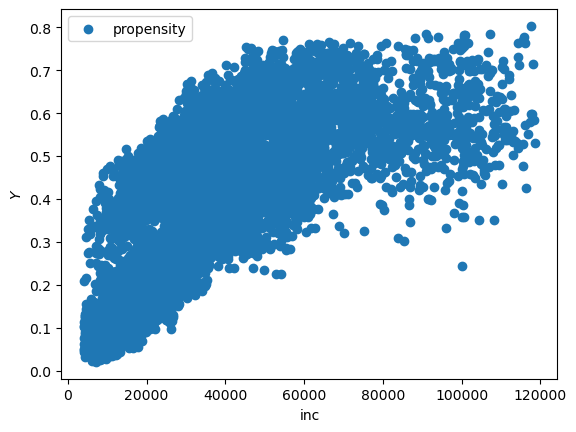

In [67]:
m = mu.predict_proba(Z)[:, 1]
plt.scatter(X[xfeat], m, label=f'propensity')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [28]:
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
tauDRXW = reg().fit(Z, Ydr, sample_weight=cov**2)

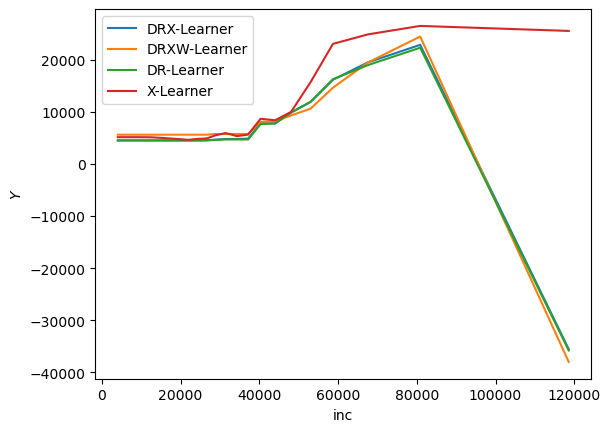

In [29]:
t0 = tau0.predict(Ztest.values)
t1 = tau1.predict(Ztest.values)
m = mu.predict_proba(Ztest.values)[:, 1]
tDRX = tauDRX.predict(Ztest.values)
tDRXW = tauDRXW.predict(Ztest.values)
tX = t1 * (1 - m) + t0 * m
plt.plot(grid, tDRX, label=f'DRX-Learner')
plt.plot(grid, tDRXW, label=f'DRXW-Learner')
plt.plot(grid, tDR, label=f'DR-Learner')
plt.plot(grid, tX,  label=f'X-Learner')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [30]:
# post-processing DRX
m = mu.predict_proba(Z)[:, 1]
t0 = tau0.predict(Z)
t1 = tau1.predict(Z)
tX = t1 * (1 - m) + t0 * m
cov = np.clip(m * (1 - m), 1e-12, np.inf)
Ydr = tX + (Yres - tX * Dres) * Dres / cov
tauDRX = reg().fit(Z, Ydr)

In [31]:
# post-processing RX
t0 = tau0.predict(Z)
t1 = tau1.predict(Z)
m = mu.predict_proba(Z)[:, 1]
tX = t1 * (1 - m) + t0 * m
tauRX = reg().fit(Z, (Yres - tX * Dres) / DresClip, sample_weight=Dres**2)

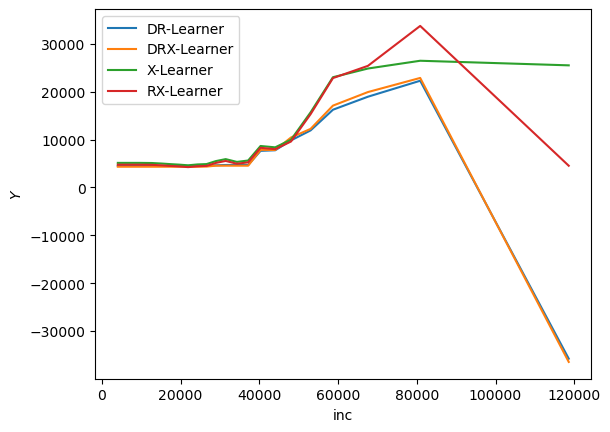

In [32]:
t0 = tau0.predict(Ztest.values)
t1 = tau1.predict(Ztest.values)
m = mu.predict_proba(Ztest.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Ztest.values)
tRX = tauRX.predict(Ztest.values) + tX

plt.plot(grid, tDR, label=f'DR-Learner')
plt.plot(grid, tDRX, label=f'DRX-Learner')
plt.plot(grid, tX,  label=f'X-Learner')
plt.plot(grid, tRX, label=f'RX-Learner')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [33]:
# correcting for covariate shift in CATE model estimation in X-Learner
m = mu.predict_proba(Z)[:, 1]

g0 = reg().fit(Z[D==0], Y[D==0], sample_weight=(1 - m[D==0]))
g1 = reg().fit(Z[D==1], Y[D==1], sample_weight=m[D==1])
tau0 = reg().fit(Z[D==0], g1.predict(Z[D==0]) - Y[D==0], sample_weight=m[D==0]**2 / (1 - m[D==0]))
tau1 = reg().fit(Z[D==1], Y[D==1] - g0.predict(Z[D==1]), sample_weight=(1 - m[D==1])**2 / m[D==1])

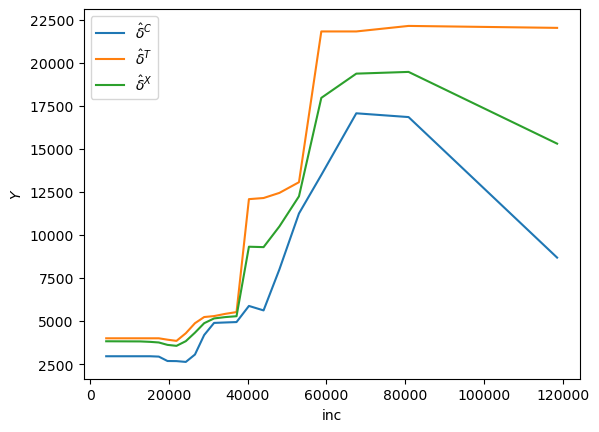

In [34]:
t0 = tau0.predict(Ztest.values)
t1 = tau1.predict(Ztest.values)
m = mu.predict_proba(Ztest.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.plot(grid, t0,  label='$\hat{\delta}^C$')
plt.plot(grid, t1, label='$\hat{\delta}^T$')
plt.plot(grid, tX,  label='$\hat{\delta}^X$')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [35]:
# from sklearn.model_selection import cross_val_predict, KFold

# m = cross_val_predict(clf(), Z, D, method='predict_proba')[:, 1]
# g0preds, g1preds = np.zeros(Y.shape), np.zeros(Y.shape)
# for train, test in KFold().split(Z, D):
#     g1preds[test] = reg().fit(Z[train][D[train]==1], Y[train][D[train]==1]).predict(Z[test])
#     g0preds[test] = reg().fit(Z[train][D[train]==0], Y[train][D[train]==0]).predict(Z[test])

# gpreds = g1preds * D + g0preds * (1 - D)
# Ydr = (Y - gpreds) * (D - m)/(m * (1 - m)) + g1preds - g0preds
# tauDR = reg().fit(Z, Ydr)

In [36]:
# grid = np.linspace(0, 1, 20)

# t0 = tau0.predict(grid.reshape(-1, 1))
# t1 = tau1.predict(grid.reshape(-1, 1))
# tDR = tauDR.predict(grid.reshape(-1, 1))
# m = mu.predict_proba(grid.reshape(-1, 1))[:, 1]
# plt.plot(grid, tDR, label='DR-Learner')
# plt.plot(grid, t1 * (1 - m) + t0 * m,  label='X-Learner')
# plt.xlabel('$Z$')
# plt.ylabel('$Y$')
# plt.legend()
# plt.show()